In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

properties = ["homo", "lumo", "r2"]

prop_norm_df = create_or_load_property_norm_df()
    
# create dataset and dataloaders
dataset = create_qm9_dataset(
    device=device, 
    include_hydrogen=False,
    refresh_data_cache=False,
    properties=properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

mol_indices = [8, 190, 59, 101]
mol_indices = [101]

batch_size = 256
val_loader = DataLoader(val_dataset[mol_indices], batch_size=batch_size, shuffle=False)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# old: ./checkpoints/graph_vae_20240416_221922.pt
model = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240502_125508.pt").to(device)
model.eval()
# old: ./checkpoints/graph_vae_20240416_225315.pt
model_split = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240503_021631.pt").to(device)
model_split.eval()
print()

In [ ]:
full_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
dataset_smiles_with_prop = dict()
for batch in tqdm(full_loader, desc="Converting dataset graphs to SMILES"):
    for sample_index in range(len(batch)):
        sample = batch[sample_index]
        mol = graph_to_mol(data=sample, includes_h=include_hydrogen, validate=False)
        dataset_smiles_with_prop[Chem.MolToSmiles(mol)] = model.denormalize_properties(sample.y)

# Inverse Design

In [3]:
import pyro
import pyro.distributions as dist

def pyro_model(y_obs):
    # Define the prior on the latent variables z
    z = pyro.sample("z", dist.Normal(torch.zeros(128, device=device), torch.ones(128, device=device))).unsqueeze(0) # dim_z is the dimension of your latent space

    # Pass the latent variables through the neural network
    y_mu, y_sigma = model.predict_properties(z)

    # Define the likelihood of the observed data
    with pyro.plate("data"):
        pyro.sample("obs", dist.Normal(y_mu, y_sigma), obs=y_obs)

In [19]:
from pyro.infer import MCMC, NUTS

# Define the MCMC kernel, here using NUTS, which is good for continuous parameters
nuts_kernel = NUTS(pyro_model)

# Run the MCMC sampler
mcmc = MCMC(nuts_kernel, num_samples=1500, warmup_steps=500)
mcmc.run(y_obs=val_dataset[mol_indices][0].y.to(device))  # replace with your actual observed data

# Get the posterior samples
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 2000/2000 [06:14,  5.33it/s, step size=1.85e-01, acc. prob=0.795]


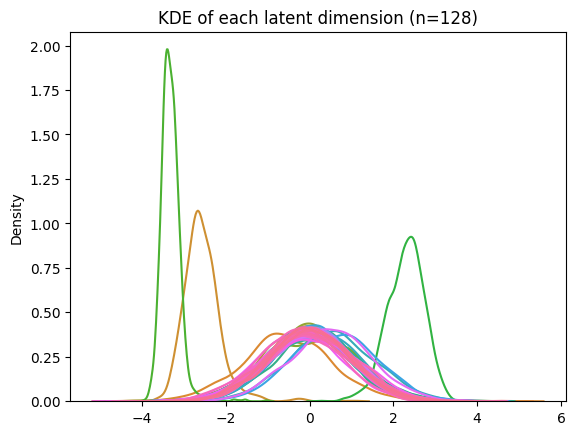

In [20]:
z = posterior_samples["z"].detach().cpu()
latent_dim = model.latent_dim
for dim in range(z.shape[1]):
    sns.kdeplot(z[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])

plt.title(f'KDE of each latent dimension (n={latent_dim})')
plt.show()

100%|██████████| 51/51 [00:05<00:00,  9.10it/s]


Encoded 12806 molecules.


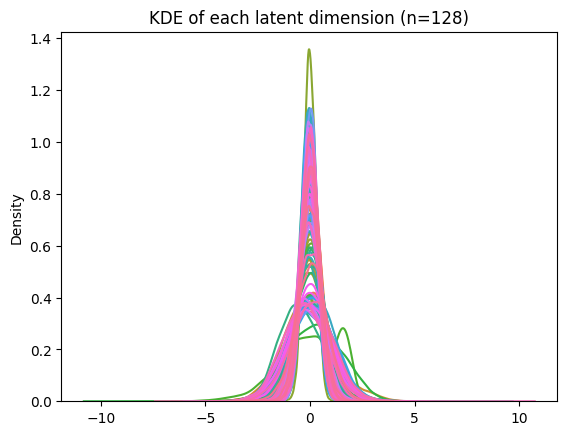

In [45]:
def plot_latent_kde(model: GraphVAE, val_loader: DataLoader):
    """ Plot a kernel density estimate of the distribution of ~5000 encoded validation molecules along each dimension of the latent space. """

    z_list = []
    num_molecules = 0
    for batch in tqdm(val_loader):
        with torch.no_grad():
            z = model.encode(batch)
        z_list.append(z)
        num_molecules += len(batch)

    z = torch.concat(z_list, dim=0).detach().cpu()
    print(f"Encoded {num_molecules} molecules.")

    latent_dim = model.latent_dim
    for dim in range(z.shape[1]):
        sns.kdeplot(z[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])

    plt.title(f'KDE of each latent dimension (n={latent_dim})')
    plt.show()

plot_latent_kde(model, DataLoader(val_dataset, batch_size=batch_size, shuffle=False))

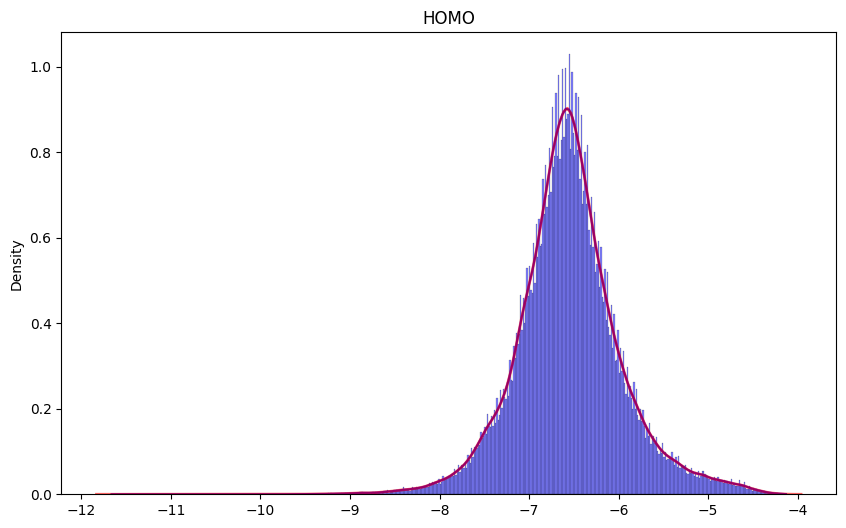

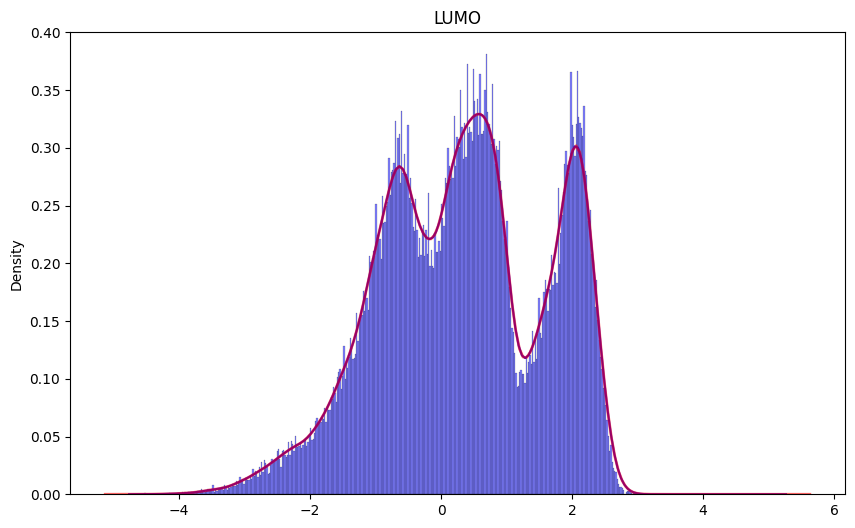

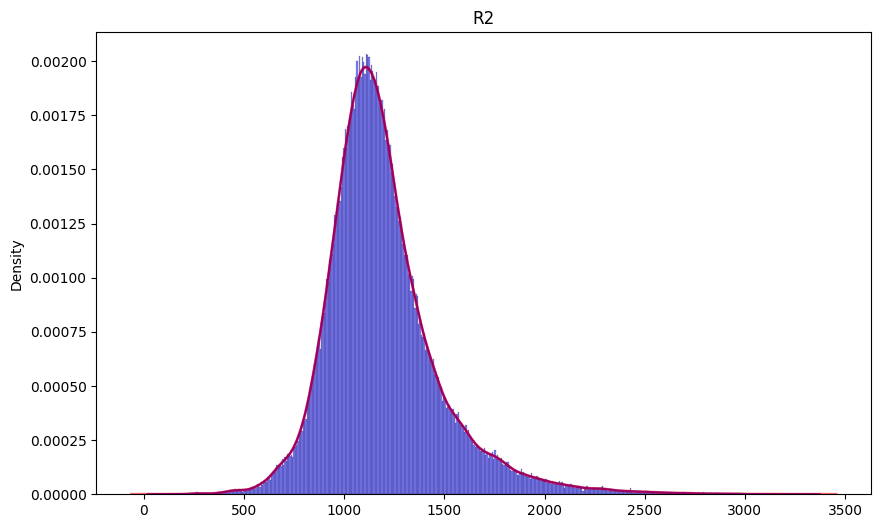

In [53]:
y_list = [y for y in dataset_smiles_with_prop.values()]
y = torch.cat(y_list, dim=0)
for i, property in enumerate(model.properties):
    # Convert tensor to numpy array and move to CPU
    data = y[:, i].cpu().numpy()
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=512, kde=True, stat='density', color='blue')
    sns.kdeplot(data, color='red', linewidth=2, alpha=0.6)
    plt.title(property.upper())
    plt.show()

100%|██████████| 1500/1500 [00:45<00:00, 32.74it/s]


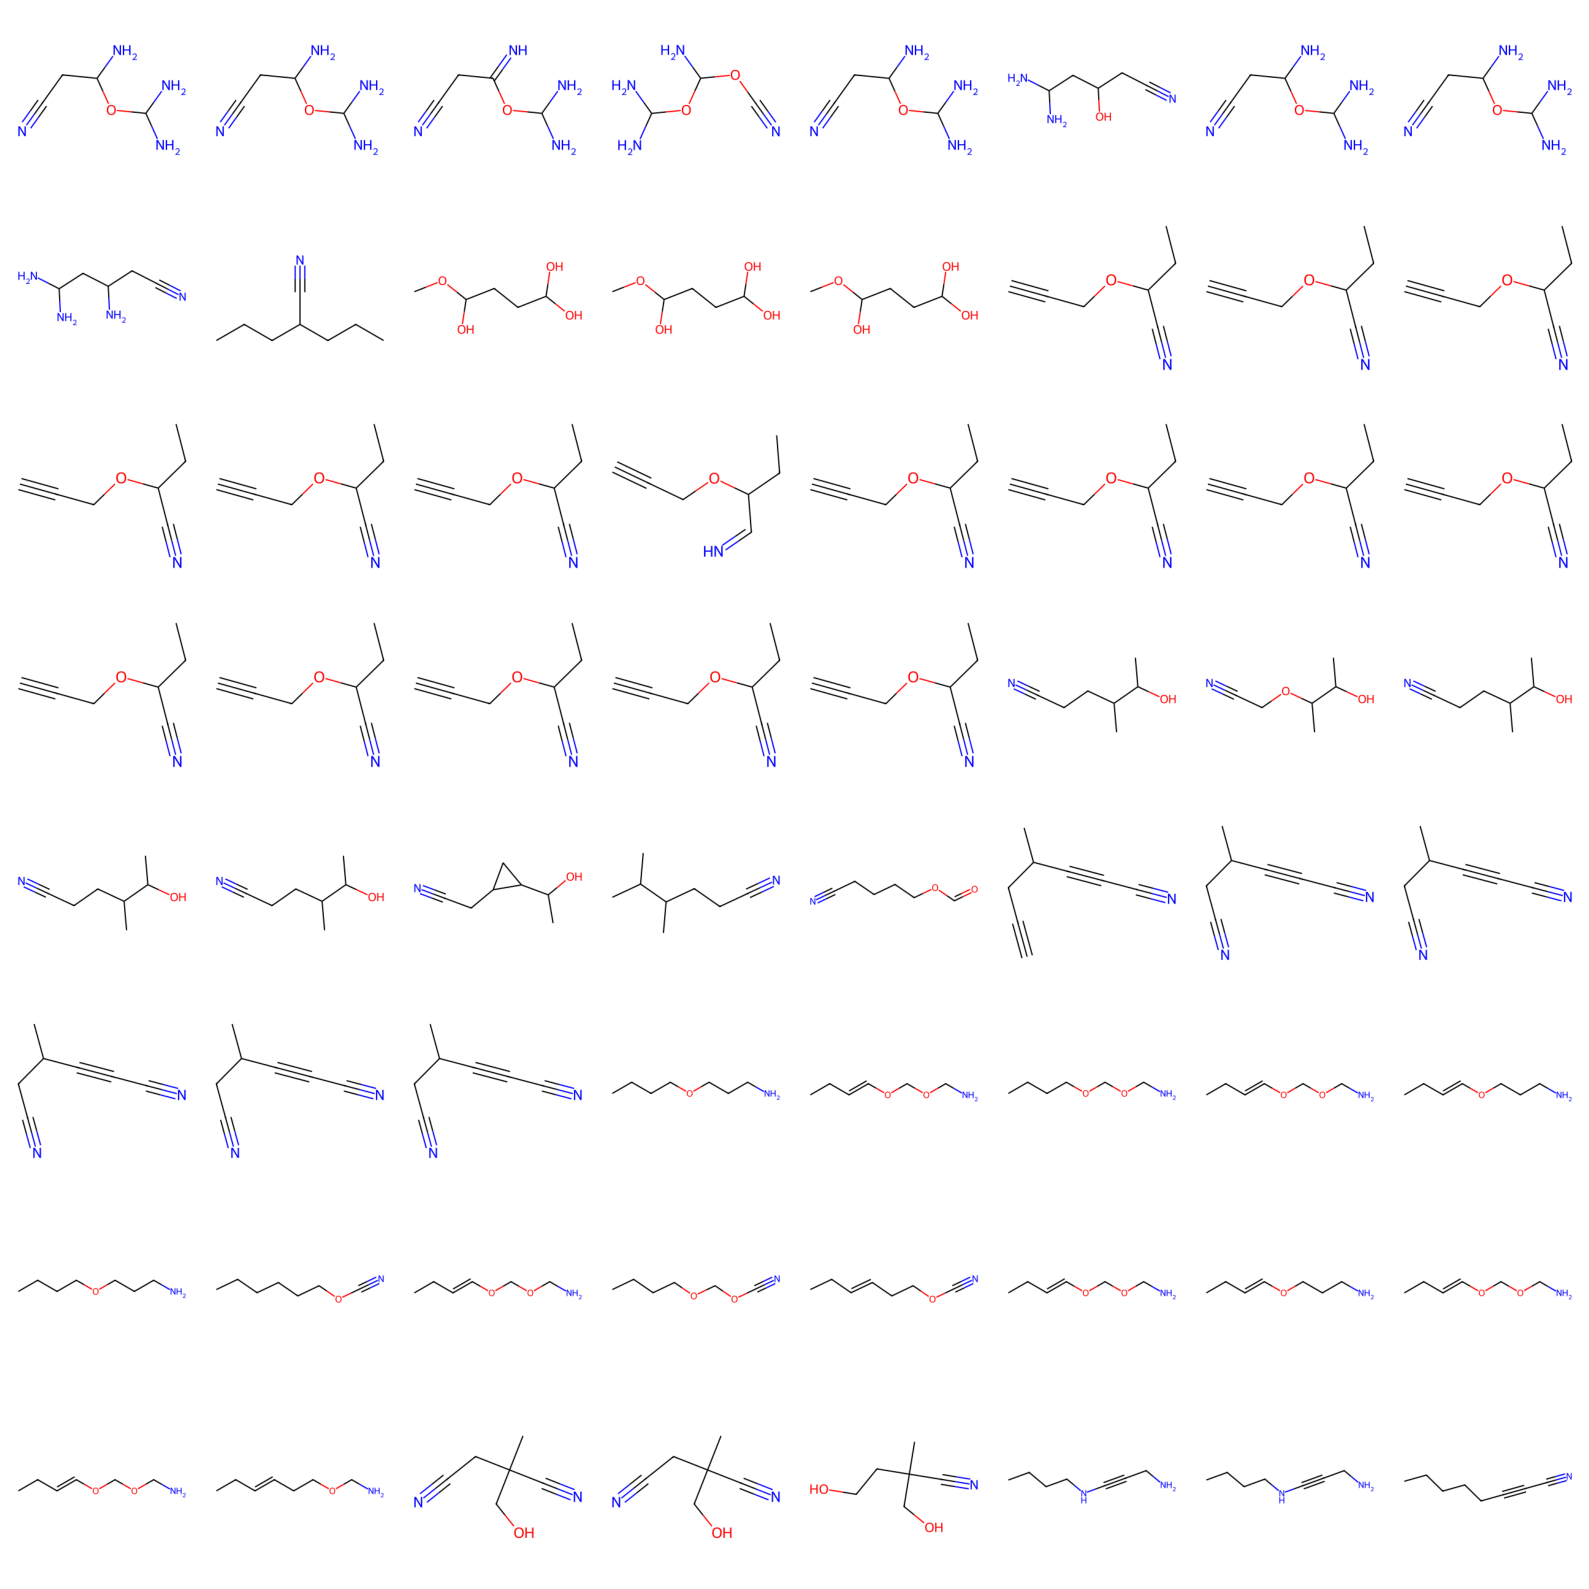

2016
Validity = 3.37


In [57]:
fig, axs = plt.subplots(8, 8, figsize=(16, 16))
axs = axs.flatten()

x = model.decode(z=posterior_samples["z"])
num_valid = 0
count = 1500
fig_index = 0
dataset_mol_count = 0
y_sample_list = []
for i in tqdm(range(count)):
    sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

    for _ in range(16):
        sample_graph = model.output_to_graph(x=sample_matrices, stochastic=True)

        # Check if the generated graph is connected
        if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
            continue

        try:
            mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
        except Exception as e:
            # Molecule is invalid; try to decode again
            continue

        # Molecule is valid
        if mol:
            
            num_valid += 1
            
            if fig_index < 64:
                img = Draw.MolToImage(mol)
                axs[fig_index].imshow(img)
                axs[fig_index].axis("off")

            smiles = Chem.MolToSmiles(mol)
            if smiles in dataset_smiles_with_prop:
                y_sample_list.append(dataset_smiles_with_prop[smiles])
                dataset_mol_count += 1
                
            fig_index += 1

plt.tight_layout()
plt.show()
print(dataset_mol_count)
print(f"Validity = {(num_valid / count):.2f}")

In [51]:
target_props = model.denormalize_properties(val_dataset[mol_indices][0].y).cpu().numpy()
target_props

array([[  -8.098108 ,   -1.9837099, 1628.6702   ]], dtype=float32)

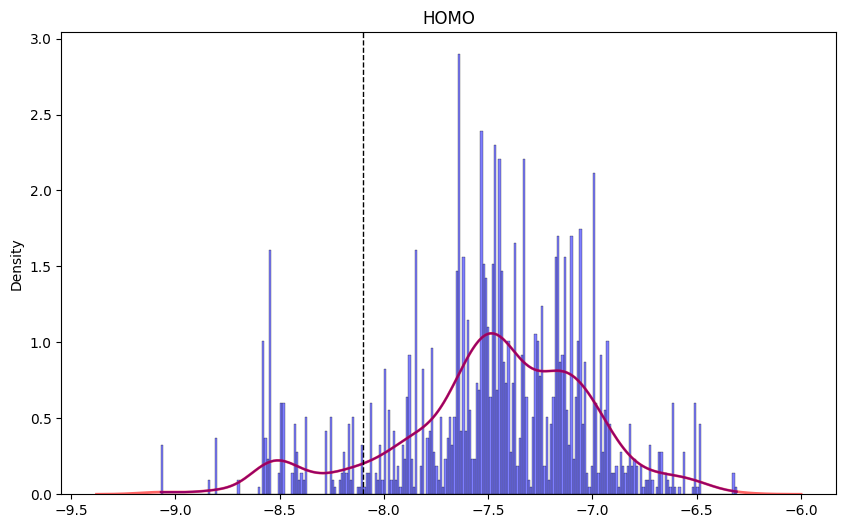

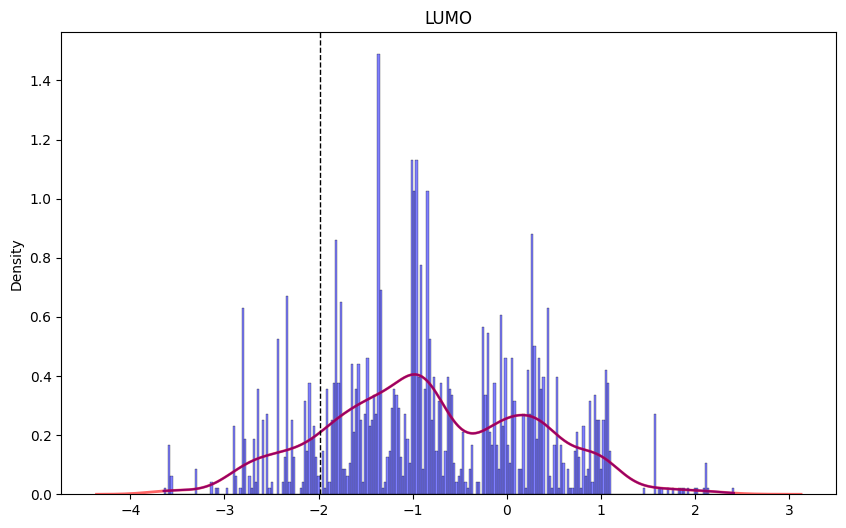

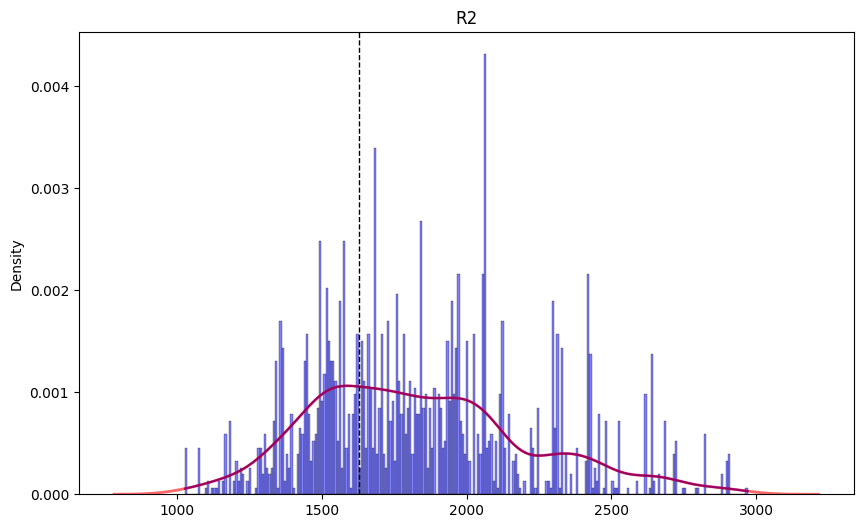

In [59]:
y = torch.cat(y_list, dim=0)
for i, property in enumerate(model.properties):
    data = y[:, i].cpu().numpy()
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=256, kde=True, stat='density', color='blue')
    sns.kdeplot(data, color='red', linewidth=2, alpha=0.6)
    plt.axvline(target_props[:, i], color='k', linestyle='dashed', linewidth=1)
    plt.title(property.upper())
    plt.show()

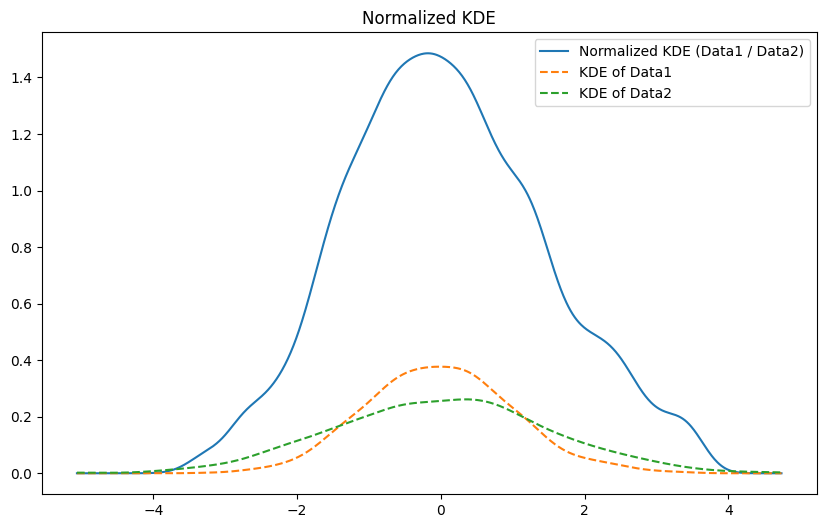

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Sample data for demonstration
data1 = np.random.normal(0, 1, 1000)  # First dataset
data2 = np.random.normal(0, 1.5, 1000)  # Second dataset to normalize by

# Generate a common grid of x values (for KDE evaluation)
x_grid = np.linspace(min(np.min(data1), np.min(data2)), max(np.max(data1), np.max(data2)), 1000)

# Compute KDE for both datasets
kde1 = gaussian_kde(data1)
kde2 = gaussian_kde(data2)

# Evaluate KDEs on the common grid
kde_values1 = kde1(x_grid)
kde_values2 = kde2(x_grid)

# Normalize first KDE by the second
normalized_kde_values = kde_values1 / kde_values2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_grid, normalized_kde_values, label='Normalized KDE (Data1 / Data2)')
plt.plot(x_grid, kde_values1, label='KDE of Data1', linestyle='--')
plt.plot(x_grid, kde_values2, label='KDE of Data2', linestyle='--')
plt.title('Normalized KDE')
plt.legend()
plt.show()
